In [1]:
#from sotodlib import core
import numpy as np
import so3g
from scipy.optimize import curve_fit
from scipy.interpolate import RectBivariateSpline
import ephem
from datetime import datetime
from so3g.proj import coords, quat
from astropy.table import Table
import re, os, pickle
import matplotlib.pyplot as plt


In [2]:
def load_beam_txt(filename):
    meta = {}
    mode = 'preamble'
    data = []
    for line in open(filename, 'rb'):
        line = line.decode('latin_1')
        #print(mode)
        if mode == 'preamble':
            if (line.strip() == 'HUYGENS PSF'):
                mode = 'header'

        elif mode == 'header':
            if line.strip() == '':
                mode = 'data'
            for regstr, key, nelem, cast in [
                    ('(.*) .m at (.*), (.*) mm', 'params', 3, float),
                    ('Data spacing is (.*) deg.', 'spacing', 1, float),
                    ]:
                m = re.search(regstr, line)
                if m is not None:
                    vals = [cast(m.group(i+1)) for i in range(nelem)]
                    if len(vals) == 1:
                        vals = vals[0]
                    meta[key] = vals

        elif mode == 'data':
            w = line.split()
            data.append(list(map(float, w)))

    data = np.array(data)
    return data, meta


(array([63]), array([64]))


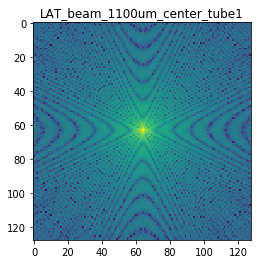

In [3]:
name = 'LAT_beam_1100um_center_tube1'
#path = '/home/jorlo/dev/gaussian_beams/'

#data, meta = load_beam_txt(path+name+'.TXT')

p_name = 'LAT_beam_270GHz_center_tube' 
p_path = '/home/jorlo/dev/pwg-scripts/pwg-bcp/2020_03_06_LAT_UHF_Beams/'
p = pickle.load(open(p_path + p_name + '.p', 'rb'))

data = p['data']

print(np.where(data == np.amax(data)))

plt.imshow(np.log(p['data']))
plt.title(name)
plt.savefig('../plots/' + name + "_beam.pdf")
plt.show()

In [4]:
#Function due to polarbear
def binmap(map2d, x, y, rbin):

    '''Bin a 2d map into a 1d symmteric radial profile (i.e. for B_l or radial profile)'''
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2+Y**2)
    d = np.digitize(R.flatten(), rbin)
    rbin1d = np.zeros(len(rbin))
    bin1d = np.zeros(len(rbin))
    binvar = np.zeros(len(rbin))
    binerr = np.zeros(len(rbin))
    for i in range (len(rbin)):
        rbin1d[i] = np.mean(R.flatten()[d==i+1])
        bin1d[i] = np.mean(map2d.flatten()[d==i+1])
        binvar[i] = np.var(map2d.flatten()[d==i+1])
        binerr[i] = np.sqrt(np.var(map2d.flatten()[d==i]) / len(map2d.flatten()[d==i+1]))
    return  rbin1d, bin1d, binvar, binerr

In [36]:
#Spline Data
length = p['size'][0][0]
x = np.linspace(-length/2, length/2, p['size'][1][0])

#x = np.linspace(-1,1,128)
y = x
print(len(x))
spline = RectBivariateSpline(x, y, data, kx = 3, ky = 3)

xspline = np.linspace(-1/30, 1/30, 1000)
yspline = xspline

splinedata = spline(xspline, yspline)
rbin = np.linspace(0, np.sqrt(2)*max(xspline), 1000)

print(np.where(splinedata == np.amax(splinedata)))

r, bin_data, c, d = binmap(splinedata,xspline,yspline,rbin)

128
(array([424]), array([575]))


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [37]:
#x, y , rbin = np.linspace(-length/2,length/2, length), np.linspace(-length/2,length/2, length), np.linspace(0,np.sqrt(2)*length/2, length/2)
#r, bin_data, c, d = binmap(data,x,y,rbin)

#print(r)

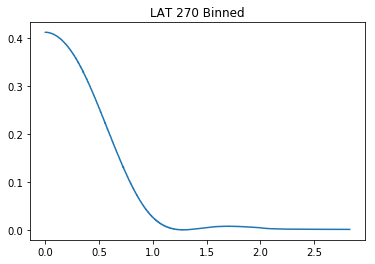

In [38]:
#print(r)
plt.plot(r*60, bin_data)
plt.title('LAT 270 Binned')
plt.savefig('test_radial_bin.pdf')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


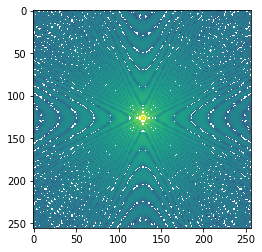

In [39]:
x = np.linspace(-length/2, length/2, 2*p['size'][1][0])
y = x

plt.imshow(np.log(spline(x,y)))
plt.savefig('interp_lat_beam.pdf')
plt.show()

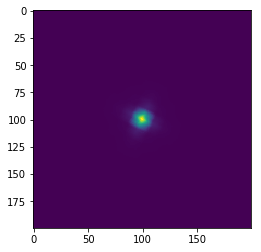

In [40]:
stack_data = pickle.load(open('stacked_map.p', 'rb'))

plt.imshow(stack_data)
plt.savefig('lat_stacked.pdf')
plt.show()


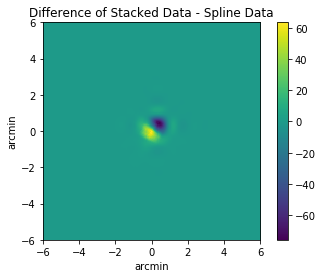

In [41]:
xspline_diff = np.linspace(-0.1, 0.1, 200)
yspline_diff = xspline_diff
spline_diff = spline(xspline_diff, yspline_diff)

spline_diff = spline_diff * np.amax(stack_data)/np.amax(spline_diff)

#plt.imshow(spline_diff)
#plt.show()

plt.imshow(stack_data-spline_diff, extent = [-6,6,-6,6])
plt.colorbar()
plt.title("Difference of Stacked Data - Spline Data")
plt.xlabel('arcmin')
plt.ylabel('arcmin')
plt.savefig('stack_spline_diff.pdf')
plt.show()

In [42]:
print('Data center: {} \n Spline Center: {}'.format(np.where(stack_data == np.amax(stack_data)), np.where(spline_diff == np.amax(spline_diff))))

Data center: (array([99]), array([99])) 
 Spline Center: (array([94]), array([105]))


(array([99]), array([99]))


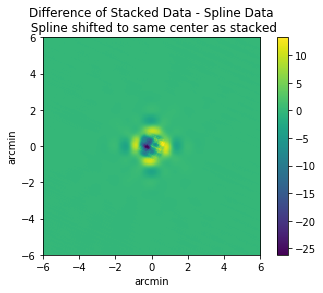

In [44]:
#Try Shifting spline

shift_spline = np.zeros([200, 200])
for i in range(5, 200):
    for j in range(0, 194):
        shift_spline[i][j] = spline_diff[i-5][j+6]
print(np.where(shift_spline == np.amax(shift_spline)))
plt.imshow(stack_data-shift_spline, extent = [-6,6,-6,6])
plt.colorbar()
plt.title("Difference of Stacked Data - Spline Data\n Spline shifted to same center as stacked")
plt.xlabel('arcmin')
plt.ylabel('arcmin')
plt.savefig('shifted_stack_spline_diff_k_3.pdf')
plt.show()
